In [1]:
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit #, Aer
from qiskit import transpile, assemble
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np
import math
#from qiskit.extensions import XGate
#from ibm_washington_config import coupling_map, basis_gates
#from ionq_config import coupling_map, basis_gates

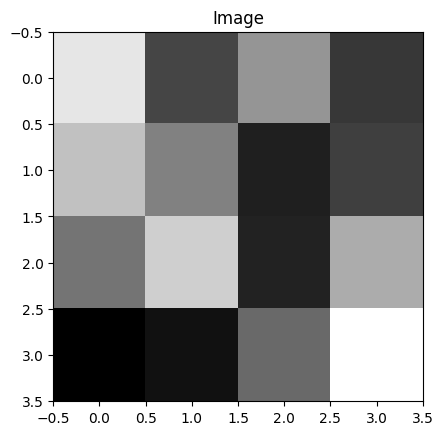

In [2]:
image = np.random.uniform(low=0, high=255, size=(4, 4)).astype(int)
plt.imshow(image, cmap='gray')
plt.title('Image')
plt.show()

w_bits = int(np.ceil(math.log(image.shape[1],2)))
h_bits = int(np.ceil(math.log(image.shape[0],2)))
if not w_bits: w_bits = 1
if not h_bits: h_bits = 1

sort pixels

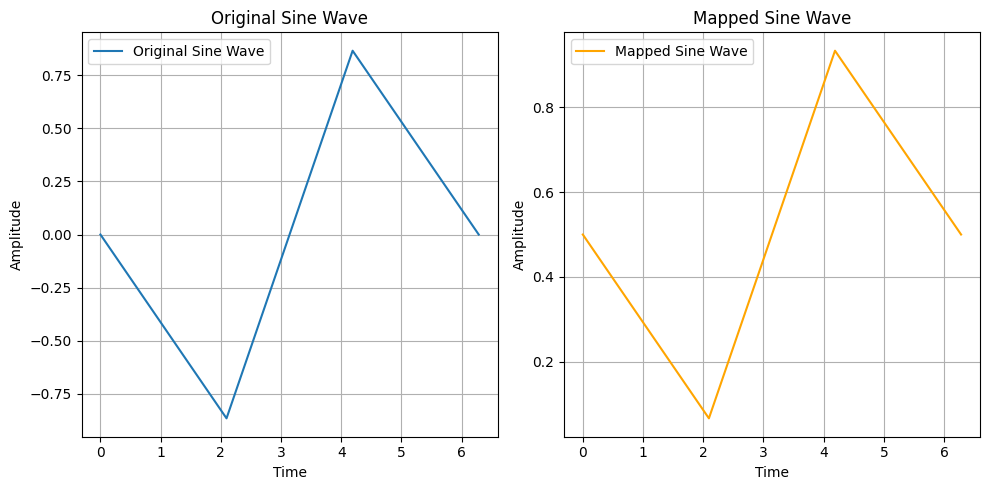

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Generate a sine wave signal
x = np.linspace(0, 2 * np.pi, 4)  # X-axis values
frequency = 5  # Frequency in Hz
amplitude = 1  # Amplitude of the sine wave
sine_wave = amplitude * np.sin(frequency * x)

# Map the sine wave to positive values
mapped_sine_wave = (sine_wave + 1) / 2  # Bijective mapping to [0, 1]

# Plot the original and mapped sine wave
plt.figure(figsize=(10, 5))

# Original sine wave
plt.subplot(1, 2, 1)
plt.plot(x, sine_wave, label='Original Sine Wave')
plt.title('Original Sine Wave')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()

# Mapped sine wave
plt.subplot(1, 2, 2)
plt.plot(x, mapped_sine_wave, label='Mapped Sine Wave', color='orange')
plt.title('Mapped Sine Wave')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [4]:
mapped_sine_wave

array([0.5      , 0.0669873, 0.9330127, 0.5      ])

In [5]:
im_list = mapped_sine_wave * 100 #image.flatten()
ind_list = sorted(range(len(im_list)), key=lambda k:im_list[k])
max_index = max(ind_list)
#now in angles: theta = intensity, phi = coordinate
thetas = np.interp(im_list, (0, 256), (0, np.pi/2))
phis = np.interp(range(len(im_list)), (0, len(im_list)), (0, np.pi/2))

In [6]:
thetas

array([0.30679616, 0.04110289, 0.57248942, 0.30679616])

In [7]:
num_ind_bits = int(np.ceil(math.log(len(im_list),2)))
if not num_ind_bits:
    num_ind_bits = 1

In [8]:
O = QuantumRegister(num_ind_bits, 'o_reg')
color = QuantumRegister(1,'amplitude')
coordinate = QuantumRegister(1, 'timestamp')
cr = ClassicalRegister(O.size+color.size+coordinate.size, "cl_reg")

qc_image = QuantumCircuit(color, coordinate, O, cr)
num_qubits = qc_image.num_qubits
input_im = image.copy().flatten()
qc_image.id(color)
qc_image.id(coordinate)
qc_image.h(O)
controls_ = []
for i, _ in enumerate(O):
    controls_.extend([O[i]])

for i, (phi, theta) in enumerate(zip(phis, thetas)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
            
    qc_image.barrier()
    
    for coord_or_intns in (0,1):
        if not coord_or_intns:
            qc_image.mcry(theta=2*theta,
                          q_controls=controls_,
                          q_target=color[0])
        else:
            qc_image.mcry(theta=2*phi,
                          q_controls=controls_,
                          q_target=coordinate[0])
       
    qc_image.barrier()
    
    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])
                
    qc_image.barrier()

qc_image.measure(list(reversed(range(qc_image.num_qubits))), list(range(cr.size)))

Metrics

| Image size  | Depth measure | # of utilized qubits |Washington depth | IonQ depth |
| ------------- | ------------- | -------------------|-----------------|------------|
| 2  | 35  | 4 | 412| 199|
| 4  | 943  | 6 | 5513| 1855|
| 8  | 16063  | 8 | 97739| 31999|
| 16  | 260863  | 10 | | 521215|
| 32  | 4189183  | 12|
| 64  | -  | 13 |
| 128  | -  | 15 |
| 256  | -  | 17 |

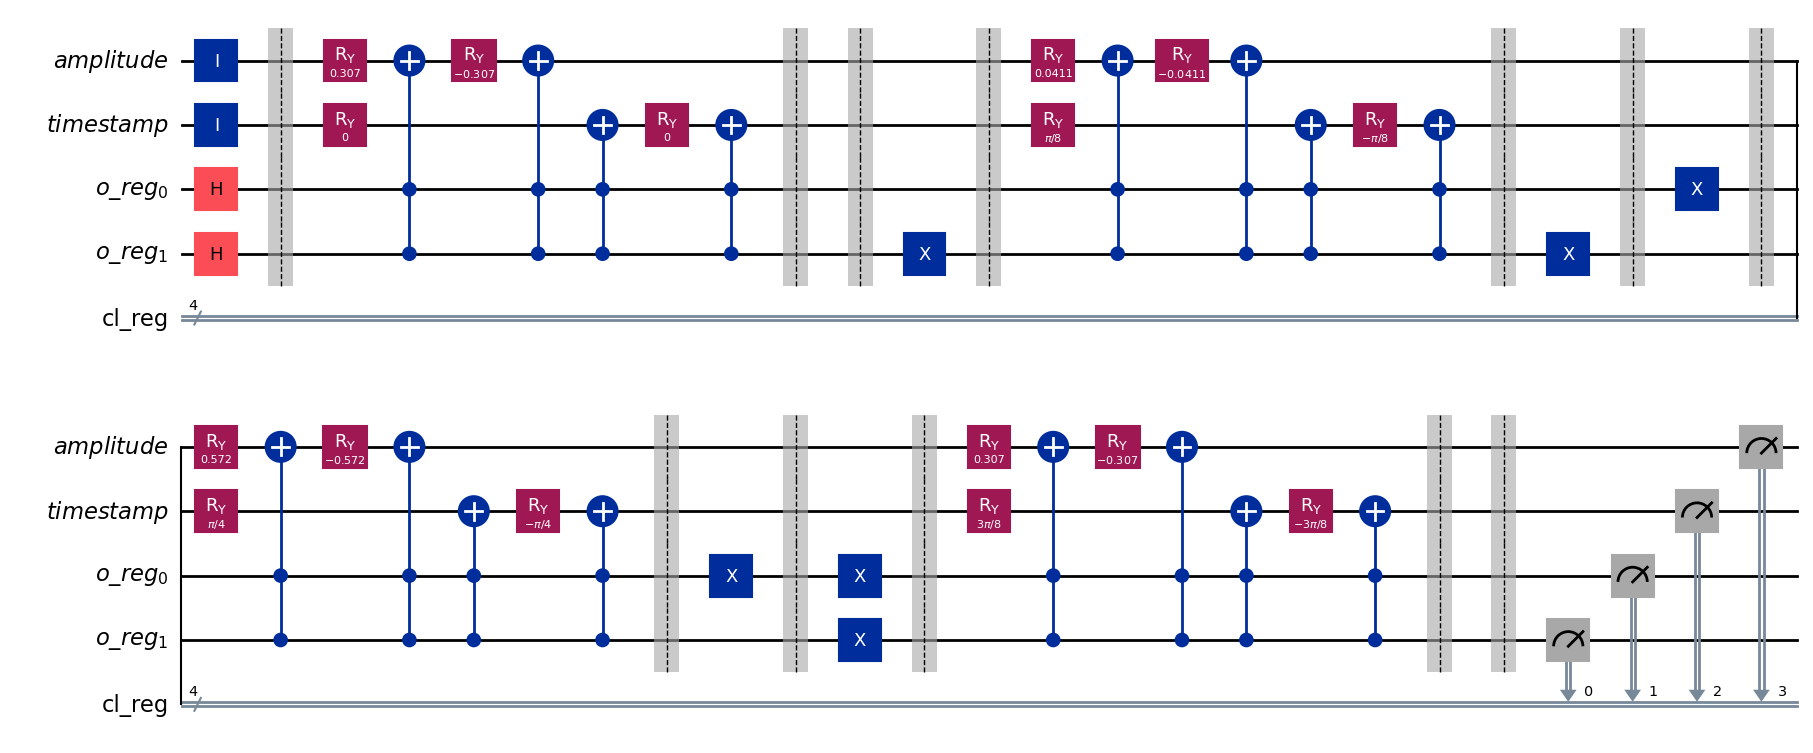

In [9]:
mpl_circuit = qc_image.draw(output='mpl')
mpl_circuit

In [10]:
print("depth is {}, # of qubits is {}".format(qc_image.depth(), qc_image.num_qubits))

depth is 35, # of qubits is 4


In [11]:
from qiskit import transpile
from qiskit_aer import AerSimulator

# Create the AerSimulator backend
aer_sim = AerSimulator()

# Transpile the quantum circuit for the simulator
t_qc_image = transpile(qc_image, aer_sim)

# Run the simulation with the specified number of shots
job_oqim = aer_sim.run(t_qc_image, shots=100000)

# Get the result of the simulation
result_oqim = job_oqim.result()

# Retrieve the measurement counts
counts_oqim = result_oqim.get_counts()
classical_colors = []
classical_coords = []
for i in range(0, max_index+1):
    color_list = []
    coord_list = []
    for item in counts_oqim.items():
        key = item[0]
        amount = item[1]
        bin_coord = key[2:]
        int_coord = int(bin_coord, 2)
        if int_coord == i:
                color_list.append((key[0], amount))
                coord_list.append((key[1], amount))
    color_amount = 0
    for color, amount in color_list:
        if not int(color):
            color_amount=color_amount+amount
    try:
        color = np.arccos((color_amount/sum(n for _, n in color_list))**(1/2))
        classical_colors.append(color)
    except ZeroDivisionError:
        print("ZeroDivisionError")
        
    coord_amount = 0
    for coord, amount in coord_list:
        if not int(coord):
            coord_amount=coord_amount+amount
    try:
        coord = np.arccos((coord_amount/sum(n for _, n in coord_list))**(1/2))
        classical_coords.append(coord)
    except ZeroDivisionError:
        print("ZeroDivisionError")
classical_colors = np.interp(classical_colors, (0, np.pi/2), (0, 256)).astype(int)
print('the meauserd colors are \n {} \n the input colors are \n {}'.format(classical_colors, im_list))
classical_coords = np.interp(classical_coords, (0, np.pi/2), (0, len(im_list))).astype(int)
print('the meauserd coordinates are \n {}'.format(classical_coords))
#output_im = classical_colors.reshape(image.shape)

the meauserd colors are 
 [50  6 92 49] 
 the input colors are 
 [50.          6.69872981 93.30127019 50.        ]
the meauserd coordinates are 
 [0 0 2 2]


In [12]:
max(classical_colors)

np.int64(92)

In [13]:
def plot_to_compare(output_im, input_im):
    plt.imshow(output_im, cmap = 'gray')
    plt.title('measured image')
    plt.show()
    plt.imshow(input_im, cmap = 'gray')
    plt.title('real image')
    plt.show()

In [14]:
#plot_to_compare(classical_colors, sine_wave)

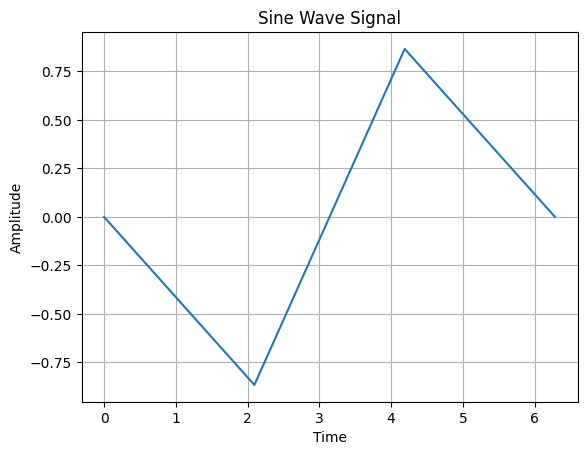

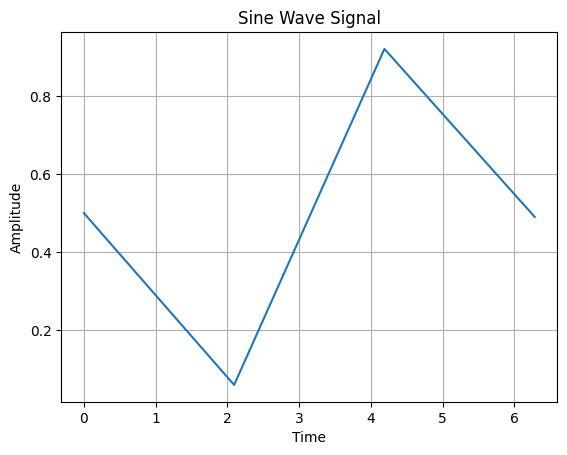

In [15]:
# Plot the sine wave
plt.plot(x, sine_wave)
plt.title('Sine Wave Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()


# Plot the sine wave
plt.plot(x, classical_colors / 100)
plt.title('Sine Wave Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()